In [7]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [26]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_table('data/Chloroplasts_removed/recalculated_mean_HNA_LNA_v2.tsv', index_col=0, header=0)
#target_new = pd.read_csv('recalculated_mean_HNA_LNA.csv', index_col=0, header=0)
#productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', sep=' ', index_col=0, header=0)
#productivity.index = productivity.samples

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [27]:
samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
index = target.index.drop(samples_to_drop)
#display(hna_lna.loc[target.loc[index,:].samples,:])

In [28]:
'''Set sample names as index and shuffle data'''
#productivity = productivity.loc[target.samples.values,:]
#productivity.index= target.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

**-- PREPROCESSING OF DATA --**

**1)**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. 

In [29]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.001

In [30]:
from analysis_functions import preprocess_df_meanabun
data_rel = preprocess_df_meanabun(data_rel,abun,False)
otus = list(data_rel.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 133


(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)

In [31]:
#Some variables to store information and to create inner and outer CV-folds

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [32]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [33]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,mi
Otu000060,132.777018,6.016226e-23,0.326565
Otu000173,130.587154,1.112906e-22,0.416207
Otu000001,89.335465,3.114176e-17,0.293372
Otu000027,54.132009,8.213227e-12,0.212336
Otu000222,48.089319,8.641329e-11,0.262000
Otu000043,42.089211,9.613147e-10,0.381542
Otu000088,41.828405,1.069283e-09,0.225269
Otu000075,40.387915,1.930086e-09,0.178088
Otu000271,39.225986,3.118288e-09,0.123149
Otu000033,38.391432,4.409313e-09,0.172165


Select otu's based on $p < \text{thr}$: 

In [34]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 78
Number of selected OTUs with p < 0.01: 59


What happens when we tune a threshold in function of the f_score: 

In [35]:
from analysis_functions import get_r2_scores
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

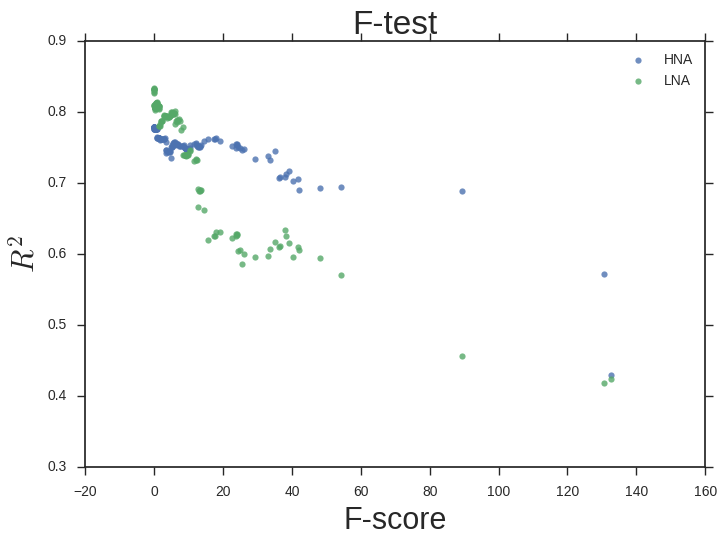

In [36]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [37]:
uni_fs.sort_values(ascending=False,inplace=True, by='mi')
display(uni_fs.head(10))
thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

,f_regr,p-value,mi
Otu000173,130.587154,1.112906e-22,0.416207
Otu000043,42.089211,9.613147e-10,0.381542
Otu000169,33.742982,3.128258e-08,0.334812
Otu000006,1.535818,2.169906e-01,0.329289
Otu000060,132.777018,6.016226e-23,0.326565
Otu000040,1.089480,2.981041e-01,0.321786
Otu000108,25.604482,1.101986e-06,0.316181
Otu000081,0.566764,4.526140e-01,0.302305
Otu000038,36.657373,9.103529e-09,0.298512
Otu000175,23.837734,2.446581e-06,0.294580


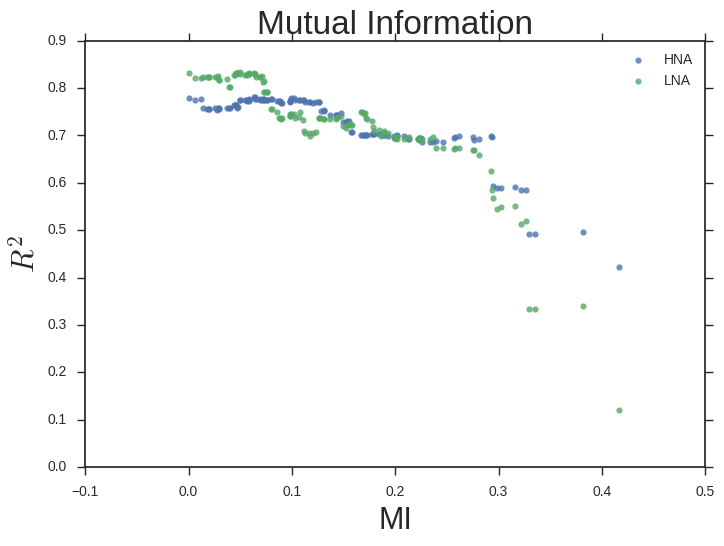

In [38]:
plt.figure()
sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
plt.xlabel('MI', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Mutual Information', size=24)
plt.legend()
plt.show()

In [39]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

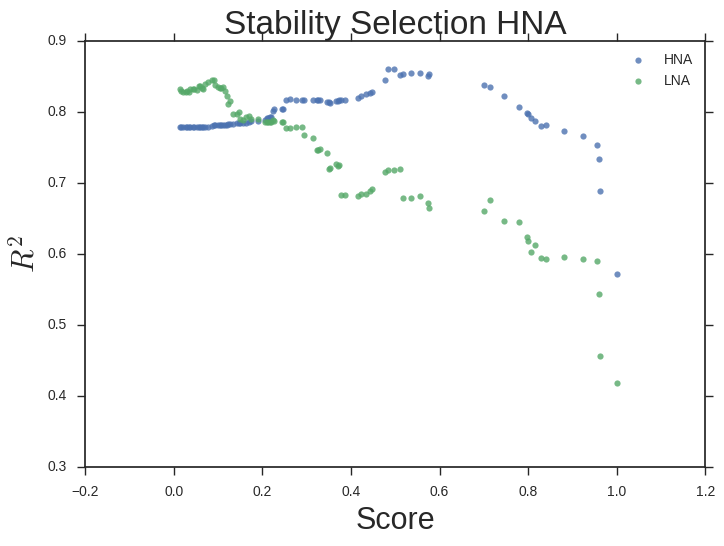

In [40]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [41]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.860716164697
Threshold score: [ 0.49666667]


In [42]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores.to_csv('Final/hnascores_otus_abun0.001_rel.csv')

In [43]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))
#display(otu_scores_selected)

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000060,1.000000,25684.048223,1.454461,0.003743,1.052154
Otu000173,1.000000,8669.419742,1.883572,0.001220,1.630473
Otu000001,0.963333,369375.389384,0.728759,0.094853,0.638430
Otu000119,0.960000,11843.959374,2.163496,0.001598,1.880754
Otu000059,0.956667,18565.540423,0.791295,0.004971,0.922406
Otu000176,0.923333,7582.179430,1.454066,0.001477,1.095974
Otu000149,0.880000,5059.495398,1.697466,0.001422,1.533150
Otu000203,0.840000,6497.374081,2.170475,0.001132,2.031292
Otu000047,0.830000,19404.490287,2.128604,0.003984,1.963976
Otu000137,0.816667,3052.074557,1.863609,0.001506,2.587881


Size list selected OTUs: 26


In [44]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.718499201432


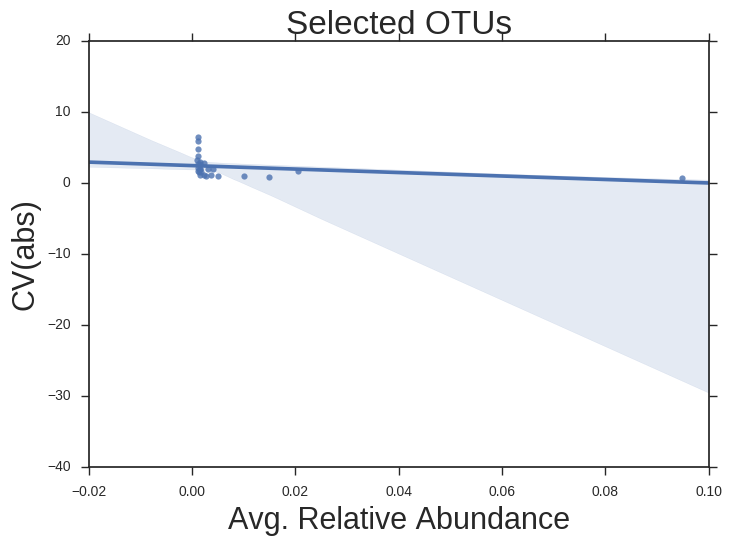

In [46]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [47]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [48]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,mi
Otu000060,126.043354,4.047601e-22,0.331849
Otu000027,116.471857,6.577028e-21,0.528304
Otu000043,76.154690,2.668252e-15,0.394261
Otu000017,61.128615,5.859941e-13,0.329664
Otu000271,59.487531,1.080045e-12,0.306697
Otu000108,59.236482,1.186438e-12,0.285471
Otu000078,55.368387,5.117994e-12,0.344321
Otu000074,54.286822,7.739726e-12,0.259819
Otu000119,52.774191,1.385254e-11,0.295980
Otu000284,48.758682,6.635031e-11,0.213255


In [49]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))

Number of selected OTUs with p < 0.05: 86
Number of selected OTUs with p < 0.01: 72


In [50]:
thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

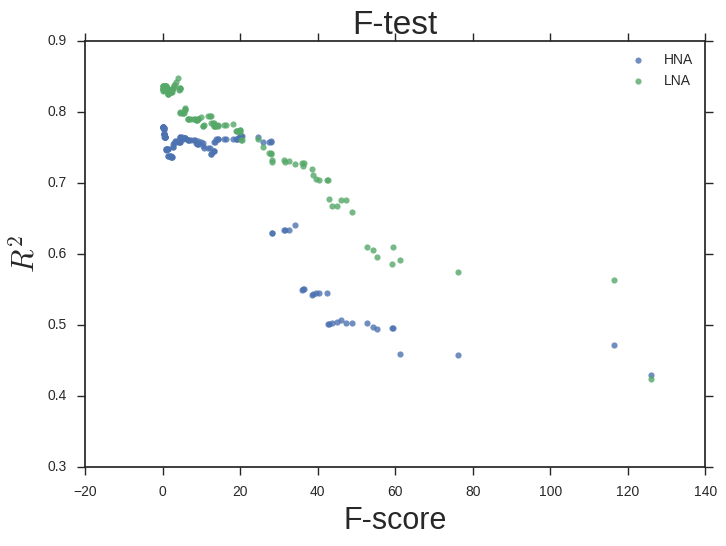

In [51]:
plt.figure()
sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
plt.xlabel('F-score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('F-test', size=24)
plt.legend()
plt.show()

In [52]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

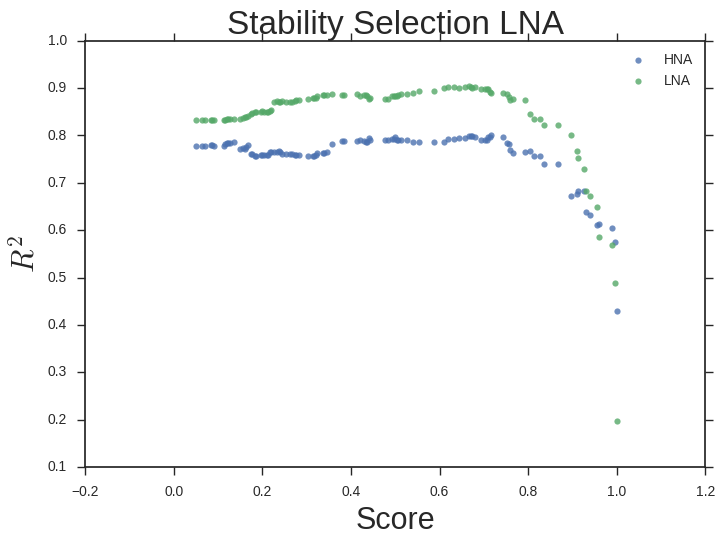

In [53]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [54]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.903483437524
Threshold score: [ 0.66666667]


In [55]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna.to_csv('Final/lnascores_otus_abun0.001_rel.csv')

In [56]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 54


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000173,1.000000,8669.419742,1.883572,0.001220,1.630473
Otu000090,1.000000,12232.231689,1.098835,0.002807,0.893969
Otu000060,0.996667,25684.048223,1.454461,0.003743,1.052154
Otu000284,0.990000,10321.717872,3.418887,0.001210,3.084120
Otu000265,0.960000,2911.009406,2.862677,0.001090,3.819897
Otu000377,0.956667,8854.675523,3.723779,0.001183,3.280850
Otu000137,0.940000,3052.074557,1.863609,0.001506,2.587881
Otu000287,0.930000,6713.766801,5.148316,0.001266,4.421028
Otu000075,0.926667,17744.740906,1.295627,0.006121,1.524125
Otu000053,0.926667,27206.280120,1.495144,0.004604,1.002453


In [57]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.798408581637


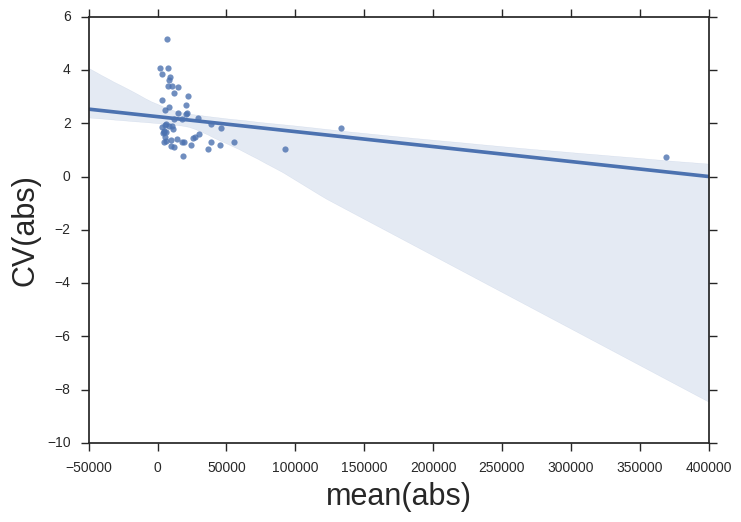

In [58]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [59]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:])
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 11; opposed to total size: 26
Size subset OTUs only related to LNA: 39; opposed to total size: 54
Size subset OTUs related to both: 15


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV
Otu000060,0.996667,25684.048223,1.454461,0.003743,1.052154
Otu000173,1.000000,8669.419742,1.883572,0.001220,1.630473
Otu000001,0.866667,369375.389384,0.728759,0.094853,0.638430
Otu000119,0.756667,11843.959374,2.163496,0.001598,1.880754
Otu000059,0.500000,18565.540423,0.791295,0.004971,0.922406
Otu000149,0.656667,5059.495398,1.697466,0.001422,1.533150
Otu000137,0.940000,3052.074557,1.863609,0.001506,2.587881
Otu000088,0.743333,4616.289407,1.293974,0.001724,1.578549
Otu000005,0.803333,132973.287096,1.819804,0.020487,1.602101
Otu000216,0.826667,7851.687244,3.398502,0.001649,2.907929


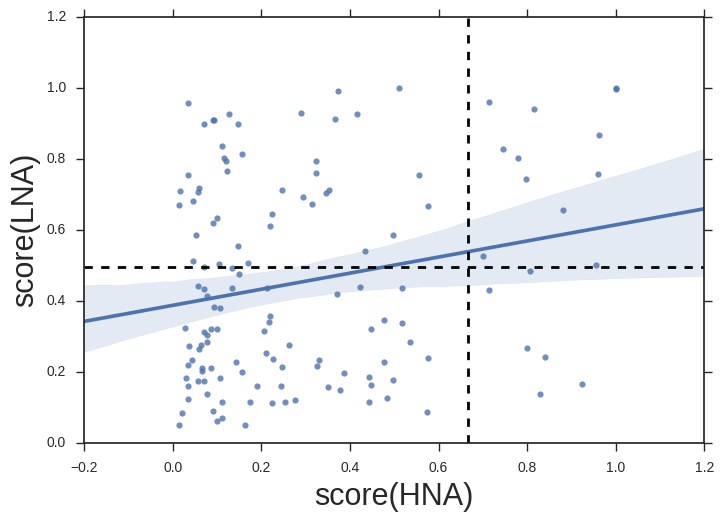

In [60]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

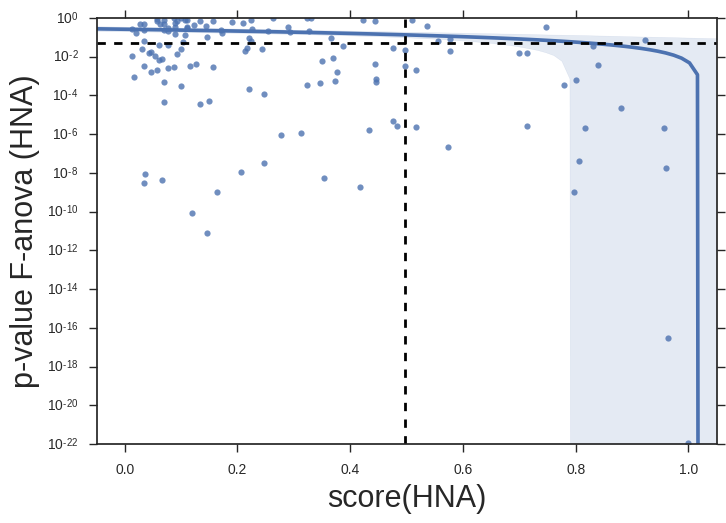

In [61]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'p-value'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (HNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.05,1.05,0.0000000000000000000001, 1])
plt.show()

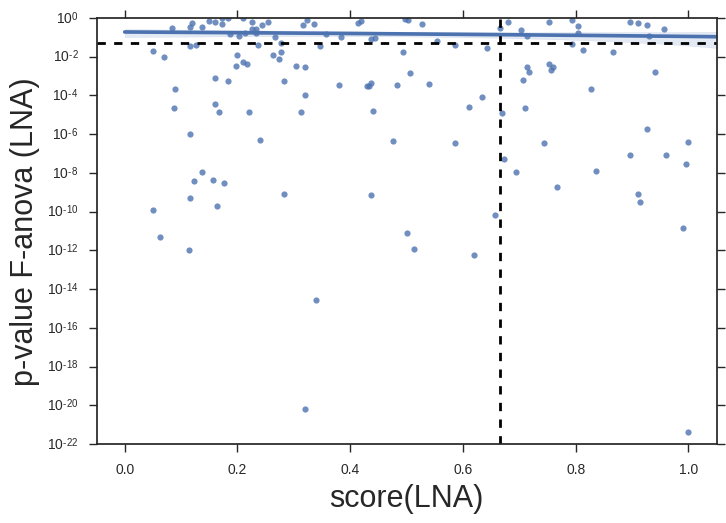

In [62]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'p-value'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('p-value F-anova (LNA)', size=22)
plt.yticks(size=10)
plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.axis([-0.05,1.05,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 